##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
orig_df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [3]:
df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)
# print(df)

In [18]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

0      0
1      0
2      1
3      2
4      0
      ..
270    0
271    0
272    2
273    0
274    1
Name: VictimCount, Length: 275, dtype: int64


In [5]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]
# print(df)

In [6]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [7]:
print(df.head())

'''
'X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time', and 'VictimCount'.
'X' and 'Y': These columns likely represent spatial coordinates. 
'Area_Command': This column probably represents the area or region where an event or incident occurred
'NIBRSOffenseCode': This column contains code for representing the type of offense reported
'DayOfWeek': This column should contain the day of the week when the incident was reported
'Time': Provides when the incident has occured
'VictimCount': No of civilians involved in the incident/crime

Above are the input variables and the output is to predict the VictimCount.
'''

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  


"\n'X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time', and 'VictimCount'.\n'X' and 'Y': These columns likely represent spatial coordinates. \n'Area_Command': This column probably represents the area or region where an event or incident occurred\n'NIBRSOffenseCode': This column contains code for representing the type of offense reported\n'DayOfWeek': This column should contain the day of the week when the incident was reported\n'Time': Provides when the incident has occured\n'VictimCount': No of civilians involved in the incident/crime\n\nAbove are the input variables and the output is to predict the VictimCount.\n"

## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [20]:
# Define your input and target variables
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']]
y = df['VictimCount']
# print(y)
unique_values, counts = np.unique(y, return_counts=True)

# print("Unique Values:", unique_values)
# print("Counts:", counts)
# Convert your data to PyTorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)

# print(X.shape[1])
# Create a PyTorch dataset from your tensors
dataset = torch.utils.data.TensorDataset(X, y)

# Define batch size
batch_size = 32

# Split your dataset into training and testing sets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for testing
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Printing train_loader data')

# Iterate over the training DataLoader and print the shape of the batched data
for batch in train_loader:
    X_batch, y_batch = batch
    print(f'X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}')

# You can do the same for the test DataLoader
print('\n\n','Printing test_loader data')

for batch in test_loader:
    X_batch, y_batch = batch
    print(f'X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}')


Unique Values: [0 1 2 3 4 5 6]
Counts: [142 100   9  21   1   1   1]
Printing train_loader data
X_batch shape: torch.Size([32, 6]), y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 6]), y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 6]), y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 6]), y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 6]), y_batch shape: torch.Size([32])
X_batch shape: torch.Size([32, 6]), y_batch shape: torch.Size([32])
X_batch shape: torch.Size([28, 6]), y_batch shape: torch.Size([28])


 Printing test_loader data
X_batch shape: torch.Size([32, 6]), y_batch shape: torch.Size([32])
X_batch shape: torch.Size([23, 6]), y_batch shape: torch.Size([23])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

# Data Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Regression model is architected here
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 1)  # Output layer with 1 unit and sigmoid activation

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))  # Sigmoid activation in the output layer
        return x

# loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Model
model = RegressionModel(input_size=X.shape[1])

# Define the optimizer (SGD) and learning rate (adjust as needed)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 150


for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        total_mse = 0
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            total_mse += criterion(predictions, batch_y).item()

        mean_mse = total_mse / len(test_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Test MSE: {mean_mse}")

/home/akhil/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/akhil/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/akhil/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  

Epoch 1/150, Test MSE: 1.0120496153831482
Epoch 2/150, Test MSE: 1.0102539360523224
Epoch 3/150, Test MSE: 1.0085432827472687
Epoch 4/150, Test MSE: 1.006804645061493
Epoch 5/150, Test MSE: 1.005157232284546
Epoch 6/150, Test MSE: 1.0035037696361542
Epoch 7/150, Test MSE: 1.0018769800662994
Epoch 8/150, Test MSE: 1.0003091096878052
Epoch 9/150, Test MSE: 0.9987283051013947
Epoch 10/150, Test MSE: 0.9972521662712097
Epoch 11/150, Test MSE: 0.9958024322986603
Epoch 12/150, Test MSE: 0.9943983852863312
Epoch 13/150, Test MSE: 0.9930040836334229
Epoch 14/150, Test MSE: 0.9916236400604248
Epoch 15/150, Test MSE: 0.9902687966823578
Epoch 16/150, Test MSE: 0.9889675378799438
Epoch 17/150, Test MSE: 0.987699419260025
Epoch 18/150, Test MSE: 0.9864456951618195
Epoch 19/150, Test MSE: 0.9851970672607422
Epoch 20/150, Test MSE: 0.9840437173843384
Epoch 21/150, Test MSE: 0.9829169511795044
Epoch 22/150, Test MSE: 0.9818277955055237
Epoch 23/150, Test MSE: 0.9807816743850708
Epoch 24/150, Test MSE:

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import numpy as np

# Data Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the number of classes based on unique class labels in your target data
num_classes = len(np.unique(y))

# print(y,'\n',np.unique(y))

# Convert y to integer values (class labels)
y = y.long()

# model for classification
class ClassificationModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# loss function (Cross-Entropy Loss)
criterion = nn.CrossEntropyLoss()

model = ClassificationModel(input_size=X.shape[1], num_classes=num_classes)

# Initlize the optimizer (SGD) and learning rate 
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 150

for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        batch_y = batch_y.long()
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        # Calculate the number of correct predictions for this batch
        _, predicted = torch.max(predictions, 1)
        total_correct += (predicted == batch_y).sum().item()
        total_samples += batch_y.size(0)

    # Calculate accuracy for this epoch
    accuracy = total_correct / total_samples

    # Evaluate the model on the test dataset
    model.eval()
    with torch.no_grad():
        total_correct_test = 0
        total_samples_test = 0
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            _, predicted = torch.max(predictions, 1)
            total_correct_test += (predicted == batch_y).sum().item()
            total_samples_test += batch_y.size(0)

        test_accuracy = total_correct_test / total_samples_test

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {accuracy * 100:.2f}%, Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/150, Train Accuracy: 43.64%, Test Accuracy: 49.09%
Epoch 2/150, Train Accuracy: 47.27%, Test Accuracy: 49.09%
Epoch 3/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 4/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 5/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 6/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 7/150, Train Accuracy: 46.82%, Test Accuracy: 49.09%
Epoch 8/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 9/150, Train Accuracy: 41.82%, Test Accuracy: 49.09%
Epoch 10/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 11/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 12/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 13/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 14/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 15/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 16/150, Train Accuracy: 52.27%, Test Accuracy: 49.09%
Epoch 17/150, Train Accuracy: 52.27%, Test Accura

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


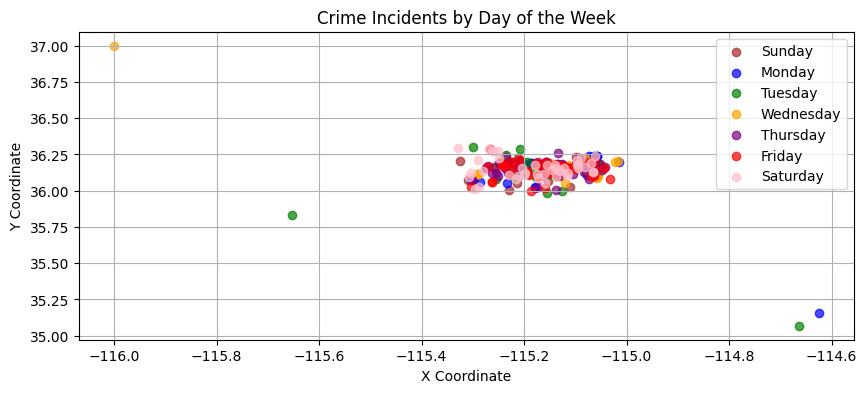

In [38]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with columns 'X', 'Y', and 'DayOfWeek'

# Define a mapping of days of the week to colors
day_to_color = {
    'Sunday': 'brown',
    'Monday': 'blue',
    'Tuesday': 'green',
    'Wednesday': 'orange',
    'Thursday': 'purple',
    'Friday': 'red',
    'Saturday': 'pink'
}

# Scatter plot
plt.figure(figsize=(10, 4))
for day, color in day_to_color.items():
    day_data = X[X['DayOfWeek'] == day]
    # print(day_data)
    plt.scatter(day_data['X'], day_data['Y'], label=day, c=color, alpha=0.7)

plt.title('Crime Incidents by Day of the Week')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


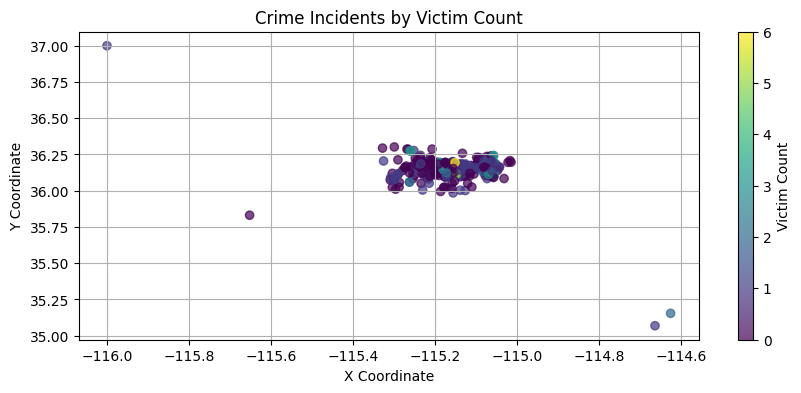

In [36]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10, 4))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', alpha=0.7)
plt.title('Crime Incidents by Victim Count')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.colorbar(label='Victim Count')
plt.grid(True)
plt.show()


In [37]:
day_counts = X['DayOfWeek'].value_counts().sort_values(ascending=False)

print(day_counts)

DayOfWeek
Friday       51
Thursday     44
Saturday     43
Monday       40
Tuesday      37
Wednesday    32
Sunday       28
Name: count, dtype: int64
